This is my my first kernel in kaggle to solve Titanic dataset.
Would appreciate your feedback and comments. And don't forget to Like if you like it!

**Solution Approach that I have followed**
1. Describe and visualize the data
2. Impute any missing values
3. Convert any Categorical features into numeric, one-hot encode.
4. Find Co-relation among all the features and the solution goal
5. Feature engineer and create/ change/ convert the features  
6. Drop/ discard any feature that is not contributing to the analysis.
7. Check for any incorrect data, outliers


In [1]:
#data analysis
import numpy as np
import pandas as pd
import re

#visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="ticks", color_codes=True)

#machine learning
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, Imputer, StandardScaler, Normalizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

In [2]:
train_data = pd.read_csv('../input/train.csv')
test_data = pd.read_csv('../input/test.csv')
combine_data = [train_data, test_data]
print(train_data.info())
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null 

Categorical features - Sex, Embarked, Survived
Ordinal - Pclass
Numerical features -
    Discrete - SibSp, Parch
    Continous - Age, Fare

First look at the data shows that - Training has 891 records and Test has 418.
There are missing values in  Age, Cabin and Embarked.
Lets impute the missing values

For Age, let us substitute the mean of the Age grouped by sex, pclass, embarked

In [3]:
#numeric data
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
#categorical data
train_data.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Doling, Mrs. John T (Ada Julia Bone)",male,347082,G6,S
freq,1,577,7,4,644


In [5]:
#view first 5 rows
print(train_data.head())

   PassengerId  Survived  Pclass    ...        Fare Cabin  Embarked
0            1         0       3    ...      7.2500   NaN         S
1            2         1       1    ...     71.2833   C85         C
2            3         1       3    ...      7.9250   NaN         S
3            4         1       1    ...     53.1000  C123         S
4            5         0       3    ...      8.0500   NaN         S

[5 rows x 12 columns]


In [6]:
#view Name feature, top 5 rows
print(train_data.Name.head())

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object


In [7]:
#Survival rate per Class. "1" class passengers have highest survival rate.
train_data[['Pclass', 'Survived']].groupby(['Pclass'], as_index = False).mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [8]:
#Survival rate Gender-wise. 
#Females-  74.2% have survived. 
#Males- 18.89% have survived.
train_data[['Sex', 'Survived']].groupby(['Sex'], as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [9]:
#compared to singles (no siblings and spouse), small families have higher survival rate
#Lagre families didnt survive
train_data[['SibSp', 'Survived']].groupby(['SibSp'], as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [10]:
#Same observation as "SibSp"
#Small families have higher survival rate, compared to passengers travelling alone and larger families
train_data[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending = False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


In [11]:
#"SibSp" and "Parch" both indicate the family size. So let us have single feature "Familysize"  
#and drop these 2 features
train_data['Familysize'] = train_data['Parch'] + train_data['SibSp'] + 1
test_data['Familysize'] = test_data['Parch'] + test_data['SibSp'] + 1

train_data = train_data.drop(['Parch', 'SibSp'], axis = 1)
test_data = test_data.drop(['Parch', 'SibSp'], axis = 1)
combine_data = [train_data, test_data]

In [12]:
#"Cabin" has lot of missing values. 204/891 are available. It doesnt help in analysis. So, drop it.
#"Ticket" value is unique for 681/891 records. Alpha numeric ticket number, shared by 210 records. 
#No visible pattern. So drop these two columns it doesnt help in analysis.

train_data = train_data.drop(['Cabin', 'Ticket'], axis = 1)
test_data = test_data.drop(['Cabin', 'Ticket'], axis = 1)

combine_data = [train_data, test_data]

In [13]:
# Define function to extract titles from passenger names
def extract_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

# Create a new feature Title, containing the titles of passenger names
for dataset in combine_data:
    dataset['Title'] = dataset['Name'].apply(extract_title)

#Check if the Titles are properly aligned as per the Sex of the passenger
pd.crosstab(train_data['Title'], train_data['Sex'])

#Title feature will help in data analysis. So, retain it.


Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [14]:
#Some rare titles can be grouped together, which have very few ( 2-3) passengers mapped.
for dataset in combine_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

In [15]:
#Survival rate based on Title
train_data[['Title', 'Survived']].groupby(['Title'], as_index = False).mean()

#Name feature can be dropped, as we have extracted the Title and this is not used further for analysis.
#PassengerId is just a sequential numbering for the data records. Can be droppped
train_data = train_data.drop(['Name', 'PassengerId'], axis = 1)
test_data = test_data.drop(['Name', 'PassengerId'], axis = 1)
combine_data = [train_data, test_data]

In [16]:
title_mapping = {'Mr' : 1, 'Miss' : 2, 'Master' : 3, 'Mrs' : 4, 'Rare' : 5}
for dataset in combine_data:
    dataset['Titlecode'] = dataset['Title'].map(title_mapping)
    dataset['Titlecode'] = dataset['Title'].fillna(0)    
train_data['Titlecode'] = train_data['Title'].map(title_mapping)
test_data['Titlecode'] = test_data['Title'].map(title_mapping)
combine_data = [train_data, test_data]

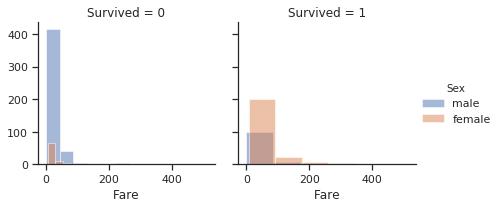

In [17]:
#Most of the passengers who have paid extremely higher price (Fare>80) have survived
#Most of the Passengers who have paid extremely lower price (Fare<20) have nor survived
# ore Females have paid higher Fare
grid = sns.FacetGrid(train_data, col='Survived', hue = "Sex")
grid.map(plt.hist, 'Fare', alpha=.5, bins = 6)
grid.add_legend();

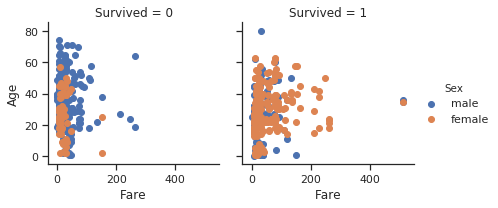

In [18]:
# Comparitively more Female pssengers have paid higher Fare
# Age >65 senior citizens are Male passengers
# oldest Male passenger has survived.
# High Fare paying passengers have survived.
grid = sns.FacetGrid(train_data, col = 'Survived', hue='Sex')
grid.map(plt.scatter, 'Fare','Age')
grid.add_legend();

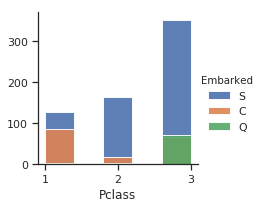

In [19]:
#Third class (Pclass = 3) embarked in either "S" or "Q"
#First class (Pclass = 1) embarked mostly in "C".
grid = sns.FacetGrid(train_data, hue='Embarked')
grid.map(plt.hist, 'Pclass',alpha = 0.9, bins=5)
grid.add_legend()

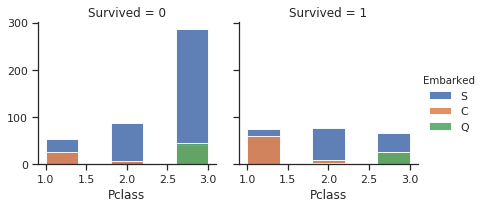

In [20]:
#First class passengers (Pclass = 1) have mostly embarked in "C". Had good survival rate.
#Third class passengers(PClass = 3) embarked in "S"have suffered the most.
grid = sns.FacetGrid(train_data, col = 'Survived', hue='Embarked')
grid.map(plt.hist, 'Pclass',alpha = 0.9, bins=5)
grid.add_legend()

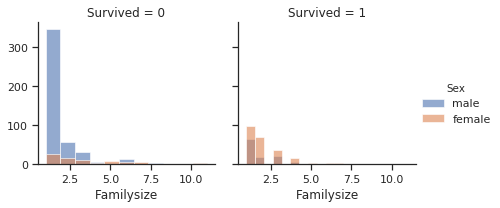

In [21]:
#Singles and larger families (Familysize>4) have least survival rate
grid = sns.FacetGrid(train_data, col = 'Survived', hue='Sex')
grid.map(plt.hist, 'Familysize',alpha = 0.6, bins=11)
grid.add_legend()

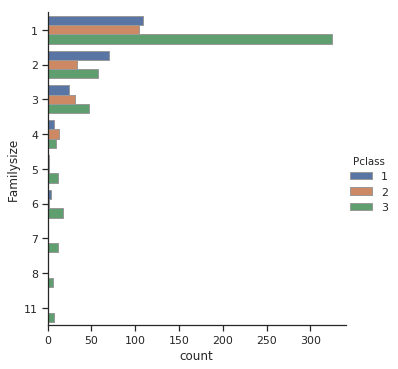

In [22]:
#Singles and larger families travelled in third class (Pclass = 3)
#Smaller families and fewer singles travelled in first or second class
sns.catplot(y="Familysize", hue="Pclass", kind="count", edgecolor=".6",data=train_data)

In [23]:
#Survival rate Familysize-wise. 
#Smaller size families have higher survival rate, together. Large families have perished together.
train_data[['Familysize', 'Survived']].groupby(['Familysize'], as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Familysize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [24]:
#Males- 18.89% have survived.
train_data[['Sex', 'Survived']].groupby(['Sex'], as_index = False).mean().sort_values(by = 'Survived', ascending = False)

pd.crosstab(train_data['Embarked'], train_data['Sex'])

Sex,female,male
Embarked,,
C,73,95
Q,36,41
S,203,441


In [25]:
#Larger families (Familysize > 4) have embarked in "S". Have least survival rate
pd.crosstab(train_data['Familysize'], [train_data['Survived'], train_data['Embarked']])

Survived     0            1         
Embarked     C   Q    S   C   Q    S
Familysize                          
1           48  34  292  37  23  101
2           17   4   51  34   5   50
3            9   4   30  14   2   43
4            1   0    7   6   0   15
5            0   0   12   2   0    1
6            0   5   14   0   0    3
7            0   0    8   0   0    4
8            0   0    6   0   0    0
11           0   0    7   0   0    0

In [26]:
#Females, minor Passengers embarked in "C" and "Q" have mostly survived.
pd.crosstab(train_data['Title'], [train_data['Survived'], train_data['Embarked']])

Survived   0            1        
Embarked   C   Q    S   C   Q   S
Title                            
Master     0   4   13   5   0  18
Miss       6   7   42  34  26  69
Mr        64  32  340  21   3  57
Mrs        3   2   21  29   1  69
Rare       2   2   11   4   0   4

In [27]:
#Almost all the children, Females travelling in first and second class have Survived. 
#However, the children travelling in third class (embarked in "S") have been penalised along with their parents.
#So families sink or survive together.
pd.crosstab(train_data['Title'], [train_data['Survived'], train_data['Pclass']])

Survived   0            1        
Pclass     1   2    3   1   2   3
Title                            
Master     0   0   17   3   9  11
Miss       2   2   51  46  33  51
Mr        70  83  283  37   8  36
Mrs        1   4   21  42  37  21
Rare       7   8    0   8   0   0

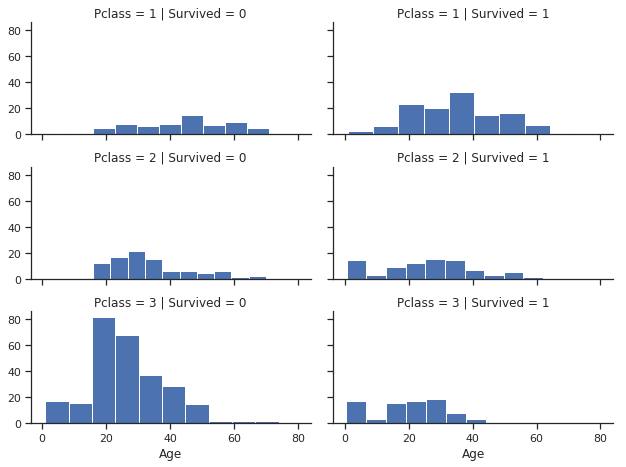

In [28]:
grid = sns.FacetGrid(train_data, col = 'Survived', row = 'Pclass', height = 2.2, aspect = 2 )
grid.map(plt.hist, 'Age', bins = 10)

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:720: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


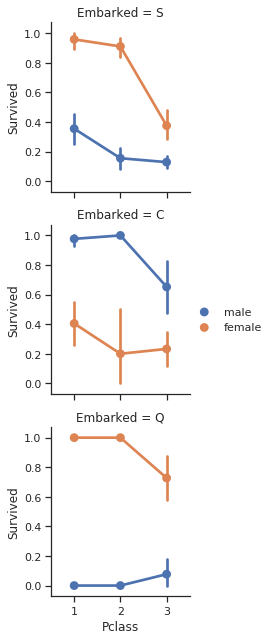

In [29]:
grid = sns.FacetGrid(train_data, row = 'Embarked')
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex',palette = 'deep')
grid.add_legend()

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


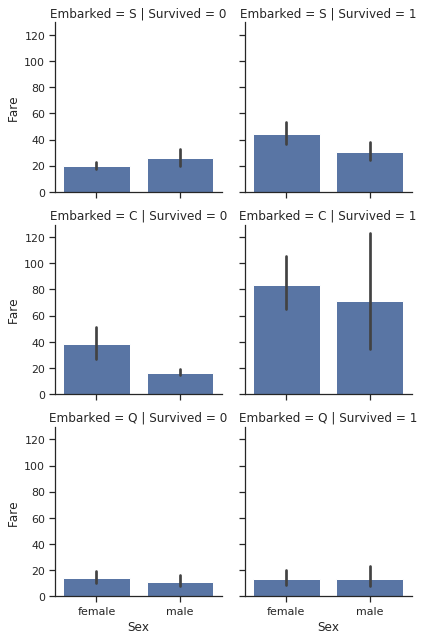

In [30]:
grid = sns.FacetGrid(train_data, row = 'Embarked', col = 'Survived')
grid.map(sns.barplot, 'Sex', 'Fare')

In [31]:
guessed_ages = np.zeros(5)
guessed_ages

array([0., 0., 0., 0., 0.])

In [32]:
#Impute the missing "Age" data. 
#Find the Median age per Title and use that to impute missing data
for dataset in combine_data:   
    for i in range(0,5):        
        guess_age = dataset[(dataset['Titlecode'] == i+1)]['Age'].dropna()
        guess_age = guess_age.median()
        guess_age = int( guess_age/0.5 + 0.5 ) * 0.5 
        guessed_ages[i] = guess_age
      
    for i in range(0,5):          
        dataset.loc[ (dataset.Age.isnull()) & (dataset.Titlecode == i+1), 'Age'] = guessed_ages[i]
    
    dataset['Age'] = dataset['Age'].astype(int)   

In [33]:
#Impute the missing "Embarked" data
#889 records have not null values. two records have missing values. 
#These can be the Mode of the dataset.
train_data['Embarked'].count() 
freq_embarked = train_data['Embarked'].mode()[0]
#print(freq_embarked)
train_data.loc[(train_data.Embarked.isnull()), 'Embarked'] = freq_embarked


In [34]:
test_data['Fare'].fillna(test_data['Fare'].dropna().median(), inplace=True)

In [35]:
#place the passengers in the bins based on their Age. 
#"pd.cut" divides the data based on the Age, into 5 bins
#train_data['AgeBins'] --> holds array-like object representing respective Age bin for each passenger


#Also, place the passengers in the bins based on the Fare.
#"pd.qcut" divides the data based on ticker fare, into ordered 5 bins.
#train_data['FareBin'] --> holds array-like object representing respective Fare bin for each passenger
for dataset in combine_data:
    dataset['AgeBin'] = pd.cut(dataset['Age'], 5)
    dataset['FareBin'] = pd.qcut(dataset['Fare'], 4)

In [36]:
# Mapping Fare
for dataset in combine_data:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
train_data.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Familysize,Title,Titlecode,AgeBin,FareBin
0,0,3,male,22,0,S,2,Mr,1,"(16.0, 32.0]","(-0.001, 7.91]"
1,1,1,female,38,3,C,2,Mrs,4,"(32.0, 48.0]","(31.0, 512.329]"
2,1,3,female,26,1,S,1,Miss,2,"(16.0, 32.0]","(7.91, 14.454]"
3,1,1,female,35,3,S,2,Mrs,4,"(32.0, 48.0]","(31.0, 512.329]"
4,0,3,male,35,1,S,1,Mr,1,"(32.0, 48.0]","(7.91, 14.454]"


In [37]:
# Mapping Age
for dataset in combine_data:
    dataset.loc[ dataset['Age'] <= 16, 'Age']  = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 
    dataset['Age'] = dataset['Age'].astype(int)
train_data.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Familysize,Title,Titlecode,AgeBin,FareBin
0,0,3,male,1,0,S,2,Mr,1,"(16.0, 32.0]","(-0.001, 7.91]"
1,1,1,female,2,3,C,2,Mrs,4,"(32.0, 48.0]","(31.0, 512.329]"
2,1,3,female,1,1,S,1,Miss,2,"(16.0, 32.0]","(7.91, 14.454]"
3,1,1,female,2,3,S,2,Mrs,4,"(32.0, 48.0]","(31.0, 512.329]"
4,0,3,male,2,1,S,1,Mr,1,"(32.0, 48.0]","(7.91, 14.454]"


In [38]:
train_data = train_data.drop(['Title','AgeBin','FareBin'], axis = 1)
test_data = test_data.drop(['Title','AgeBin','FareBin'], axis = 1)
combine_data = [train_data, test_data]

train_data.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Familysize,Titlecode
0,0,3,male,1,0,S,2,1
1,1,1,female,2,3,C,2,4
2,1,3,female,1,1,S,1,2
3,1,1,female,2,3,S,2,4
4,0,3,male,2,1,S,1,1


In [39]:
for dataset in combine_data:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

In [40]:
#there is a missing 'Sex' value in test_data
for dataset in combine_data:
    dataset['Sex'] = dataset['Sex'].map({'male' : 0, 'female' : 1}).astype(int)

train_data.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Familysize,Titlecode
0,0,3,0,1,0,0,2,1
1,1,1,1,2,3,1,2,4
2,1,3,1,1,1,0,1,2
3,1,1,1,2,3,0,2,4
4,0,3,0,2,1,0,1,1


In [41]:
#Now that all the categorical features are converted into numeric, 
#Sex --> Already one hot encoded #Age and Fare -->Ordinal data #Embarked, Pclass, Titlecode --> need to one hot encode
features = train_data[['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Familysize', 'Titlecode']]
target = train_data['Survived']
preprocess = make_column_transformer(    
    (OneHotEncoder(sparse=False), ['Pclass', 'Sex', 'Embarked','Titlecode']), 
    remainder= StandardScaler())

preprocess.transformers
train_x = preprocess.fit_transform(features)
train_y = target.values

train_x[1]

#Preprocess and transform test features
features_test = test_data[['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Familysize', 'Titlecode']]
preprocess = make_column_transformer(    
    (OneHotEncoder(sparse=False), ['Pclass', 'Sex', 'Embarked','Titlecode']), 
    remainder= StandardScaler())
preprocess.transformers
test_x = preprocess.fit_transform(features_test)
#model = make_pipeline(preprocess, LogisticRegression())
#model.fit(train_x, train_y)
#print("logistic regression score: %f" % model.score(test_x, test_y))


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/opt/c

In [42]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
import keras
#from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import graphviz

Using TensorFlow backend.


In [43]:
#creating the model
def build_classifier(optimizer):  
    #initialize ANN
    classifier = Sequential()
    #Adding the input parameters and first layer to ANN
    classifier.add(Dense(units = 20, 
                         kernel_initializer = 'uniform', 
                         activation = 'relu', 
                         input_dim = 16))
    
    #Adding the dropout layer
    classifier.add(Dropout(0.5))
    
    #Adding the second layer to ANN
    classifier.add(Dense(units = 60, 
                         kernel_initializer = 'uniform', 
                         activation = 'relu'))
    
    #Adding the dropout layer
    classifier.add(Dropout(0.5))
    
    #Adding the output layer that is binary
    classifier.add(Dense(units = 1, 
                         kernel_initializer = 'uniform', 
                         activation = 'sigmoid'))
    
    classifier.summary()
    
    #with the scalar sigmoid output on a binary classification problem, use the binary cross entropy loss function
    classifier.compile(optimizer = optimizer, 
                       loss = 'binary_crossentropy', 
                       metrics = ['accuracy'] )
    
    return classifier

#Use KerasClassifier
classifier = KerasClassifier(build_fn = build_classifier)

#create a dictionary for the hyper parameters
parameters = {'batch_size' : [60, 30],
               'nb_epoch' : [30, 50],
               'optimizer' : ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']}

# 'optimizer' : ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']}
#GridSearchCV implements fit and predict
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 3)

grid_search = grid_search.fit(train_x, train_y)
best_estimator = grid_search.best_estimator_
best_parameters = grid_search.best_params_
best_score = grid_search.best_score_



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                340       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 60)                1260      
_________________________________________________________________
dropout_2 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 61        
Total params: 1,661
Trainable params: 1,661
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1
594/594 [==============================] - 1s 886us/step - loss: 0.6928 - acc: 0.5707
____________________________________________

In [44]:
print("best_estimator %s" %best_estimator)
print("best_parameters %s" %best_parameters)
print("best_score %f" %best_score)

best_estimator <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f6548fe4080>
best_parameters {'batch_size': 60, 'nb_epoch': 30, 'optimizer': 'Adagrad'}
best_score 0.729517
